In [1]:
from typing import Optional
import argparse
import os
import sys

import torch
import matplotlib.pyplot as plt     # type: ignore

import utilities
import model
import optimize
import pandas as pd

from utils import default_paths

import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

info_fn = os.path.join(default_paths.stim_root, 'Indep_set_info.csv')
print('\nloading image info from %s\n'%info_fn)
info_df = pd.read_csv(info_fn, index_col=0)


cuda

loading image info from /user_data/mmhender/nsd/stimuli/Indep_set_info.csv



In [4]:
fn_info = os.path.join(os.getcwd(),'vgg19_rfs_info.npy')
rfs_info = np.load(fn_info, allow_pickle=True).item()    

In [5]:
rfs_info.keys()

dict_keys(['pixel_centers', 'layer_unit_centers', 'layer_names_use', 'layer_inds'])

In [6]:
pixel_centers = rfs_info['pixel_centers']
layer_unit_centers = rfs_info['layer_unit_centers']
layer_names = rfs_info['layer_names_use']
layer_inds = rfs_info['layer_inds']
n_layers = len(layer_names)
n_pix = np.max(pixel_centers)+1

In [8]:
rfs_each_layer = []
for ll, layer in enumerate(['Conv1','MaxPool1','MaxPool2','MaxPool3','MaxPool4']):
    fn_rfs = os.path.join(os.getcwd(),'vgg19_unit_rfs_%s.npy'%layer)
    rfs = np.load(fn_rfs)
    rfs_each_layer.append(rfs)
    

In [9]:
n_grid_eachside=4;
overlap_each_layer = []
for ll in range(n_layers):
    
    fn = os.path.join(os.getcwd(),'vgg19_gridoverlap_%dx%d_%s.npy'%(n_grid_eachside, \
                                                                    n_grid_eachside, layer_names[ll]))
    print(fn)
    overlap = np.load(fn)
    overlap_each_layer.append(overlap)

/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_4x4_Conv1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_4x4_MaxPool1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_4x4_MaxPool2.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_4x4_MaxPool3.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_4x4_MaxPool4.npy


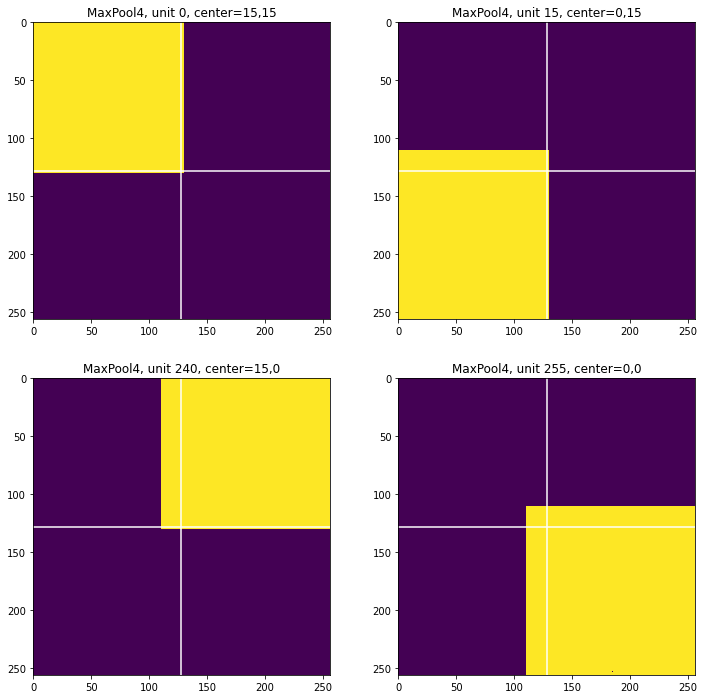

In [77]:
plt.figure(figsize=(12,12))

ll = 4;

units_plot = [0, 16-1, 16*15, 16*16-1]

pi=0
for unit in units_plot:

    pi+=1
    plt.subplot(2,2,pi)
    rf = rfs_each_layer[ll][:,unit].detach().cpu().numpy()
    rf = np.reshape(rf, [n_pix, n_pix])
    plt.pcolormesh(rf)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.axhline(n_pix/2, color='w')
    plt.axvline(n_pix/2, color='w')
    # plt.colorbar()
    plt.title('%s, unit %d, center=%d,%d'%(layer_names_use[ll], unit, \
                                           layer_unit_centers[ll][unit][0], layer_unit_centers[ll][unit][1]))

In [34]:
rfs.shape

(65536, 65536)

In [14]:

def get_vgg_activations_batch(model, image_batch, layer_inds):

    model.eval()
   
    if len(layer_inds)==0:
        raise ValueError('your layer names do not match any of those specified in alexnet_features.py')

    # first making this subfunction that is needed to get the activation on a forward pass
    def get_activ_fwd_hook(ii,ll):
        def hook(self, input, output):      
            print(vgg19_layer_names[ll])
            print(torch.any(output<0), torch.any(torch.isnan(output)))
            # if ll==9 or ll==10:
            #     print(vgg19_layer_names[ll])
            #     print(torch.any(output<0))
                # print(output.shape)
                # print(torch.unique(output))
            
            # print('hook for %s'%vgg19_layer_names[ll])           
            activ[ii] = output
            # print(output.shape)
        return hook
   
    # get image and labels for this batch
    # image_tensors is [batch_size x 3 x 224 x 224]
    activ = [[] for ll in layer_inds]
    hook = [[] for ll in layer_inds]
    
    model.eval()

    # adding this "hook" to the module corresponding to each layer, so we'll save activations at each layer
    # this only modifies the "graph" e.g. what the model code does when run, but doesn't actually run it yet.
    for ii, ll in enumerate(layer_inds):
        # print(get_vgg_layer_names()[ll])
        h = model.features[ll].register_forward_hook(get_activ_fwd_hook(ii,ll))
        hook[ii] = h
        
    print('hooks: %s'%hook)

    # do the forward pass of model, which now includes the forward hooks
    # now the "activ" variable will get modified, because it gets altered during the hook function
    # print(torch.unique(model.features[10].weight))
    # print(torch.unique(model.features[10].bias))
    # print(torch.unique(image_batch))
    model(image_batch)
    
    # Now remove all the hooks
    for ii, ll in enumerate(layer_inds):
        # print(activ[ii].shape)
        hook[ii].remove

    print('hooks: %s'%hook)
    return activ


def get_vgg_layer_names():
    
    names = []
    n_chunks = 5;
    n_convs_per_chunk = [2, 2, 4, 4, 4]
    conv_counter = 0;
    for ch in range(n_chunks):
        for cv in range(n_convs_per_chunk[ch]):   
            conv_counter+=1  
            names+= ['Conv%d'%conv_counter]
            names+= ['ReLU%d'%conv_counter]   
        names+= ['MaxPool%d'%(ch+1)]
    return names

In [15]:
def init_model():

    import torchvision.models as models
    vgg_layer_names = get_vgg_layer_names()

    model = models.vgg19(pretrained=False).float().to(device)
    # model = models.vgg19(pretrained=True).float().to(device)
    for ll, f in enumerate(model.features):
        # print(vgg_layer_names[ll], f)
        if hasattr(f, 'weight'):
            f.weight.data.fill_(1.0)
        if hasattr(f, 'bias'):
            f.bias.data.fill_(0.0)

    # print('\n')
    layers_replace = [4, 9, 18, 27, 36]
    for ll in layers_replace:
        # print(model.features[ll])
        mod = model.features[ll]
        assert(not hasattr(mod, 'weight'))
        new_mod = torch.nn.AvgPool2d(kernel_size=mod.kernel_size, stride=mod.stride, padding=mod.padding,ceil_mode=mod.ceil_mode)
        model.features[ll] = new_mod
        # print(model.features[ll])
    
    return model

In [19]:
# model

In [16]:
n_pix = 256
pixel_centers_x, pixel_centers_y = np.meshgrid(np.arange(n_pix), np.arange(n_pix))
pixel_centers = list(zip(np.ravel(pixel_centers_y), np.ravel(pixel_centers_x)))

In [20]:
vgg19_layer_names = get_vgg_layer_names()
# 
layer_names_use = vgg19_layer_names
# layer_names_use = ['ReLU1', 'MaxPool1','MaxPool2','MaxPool3','MaxPool4']
layer_inds = [np.where([n==name for n in vgg19_layer_names])[0][0] \
                                              for name in layer_names_use]

model = init_model()

template_batch = torch.Tensor(np.zeros((1,3,n_pix, n_pix))).to(device)
# template_batch[0,:,100,100] = 1.0
activs = get_vgg_activations_batch(model, template_batch, layer_inds)

template_batch = torch.Tensor(np.zeros((1,3,n_pix, n_pix))).to(device)
template_batch[0,:,100,100] = 1.0
activs = get_vgg_activations_batch(model, template_batch, layer_inds)

res_each_layer = [aa.shape[2] for aa in activs]

spatunits_each_layer = [res**2 for res in res_each_layer]

n_total_pix = n_pix**2
rfs_each_layer = [torch.zeros(size=[n_total_pix, n], dtype=bool) for n in spatunits_each_layer]

In [18]:
layer_unit_centers = []
for n_units in res_each_layer:

    unit_centers_x, unit_centers_y = np.meshgrid(np.arange(n_units), np.arange(n_units))
    
    centers = list(zip(unit_centers_y.ravel(), unit_centers_x.ravel()))
    
    layer_unit_centers.append(centers)

In [21]:
import time

batch_size=1;

n_batches = int(np.ceil(n_total_pix/batch_size))

for bb in range(500):
# for bb in range(n_batches):
# for bb in [0]:

    if np.mod(bb,50)==0:
        print('processing pixel batch %d of %d'%(bb, n_batches))

    pixels_do = np.arange(bb*batch_size, np.minimum((bb+1)*batch_size, n_total_pix))
    
    st = time.time()
    image_batch = torch.Tensor(np.zeros((len(pixels_do),3,n_pix, n_pix))).to(device)                  
    for ii, pix in enumerate(pixels_do):
        center = pixel_centers[pix]
        # print(center)
        image_batch[ii,:,center[0], center[1]] = 1.0
        
    elapsed = time.time() - st;
    # print('took %.5f s to make one-hot ims'%elapsed)
    
    st = time.time()
    with torch.no_grad():
        
        # model = init_model()
        activs = get_vgg_activations_batch(model, image_batch, layer_inds)
    elapsed = time.time() - st;
    # print('took %.5f s to get activs'%elapsed)
    
    st = time.time()
    for ll, act in enumerate(activs):
        
        a = torch.sum(act[:,:,:,:], dim=1)>0
        
        rfs_each_layer[ll][pixels_do,:] = a.reshape([len(pixels_do),-1]).detach().cpu()
        
    elapsed = time.time() - st;
    print('took %.5f s to make rfs'%elapsed)
    

In [22]:
# act

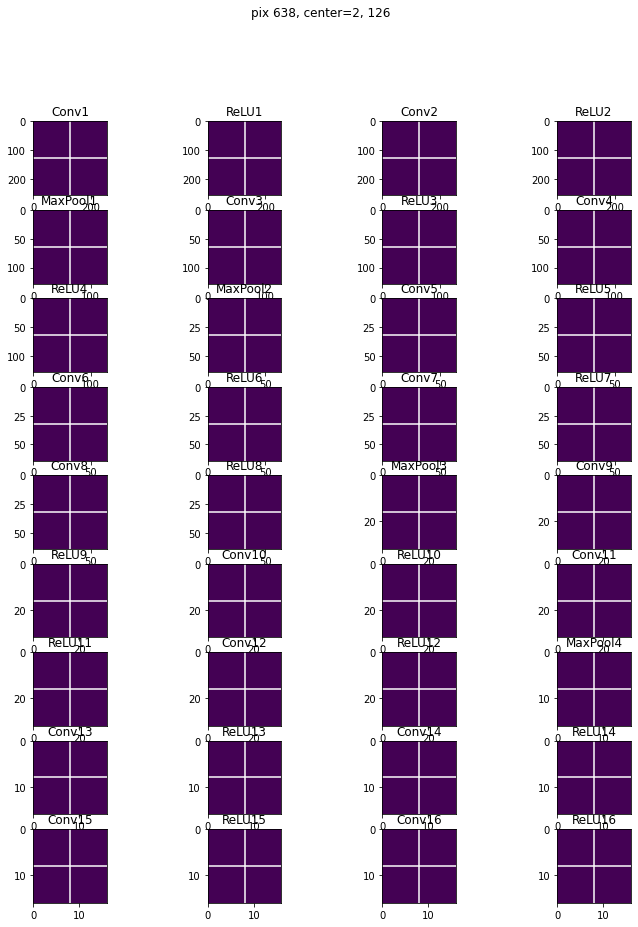

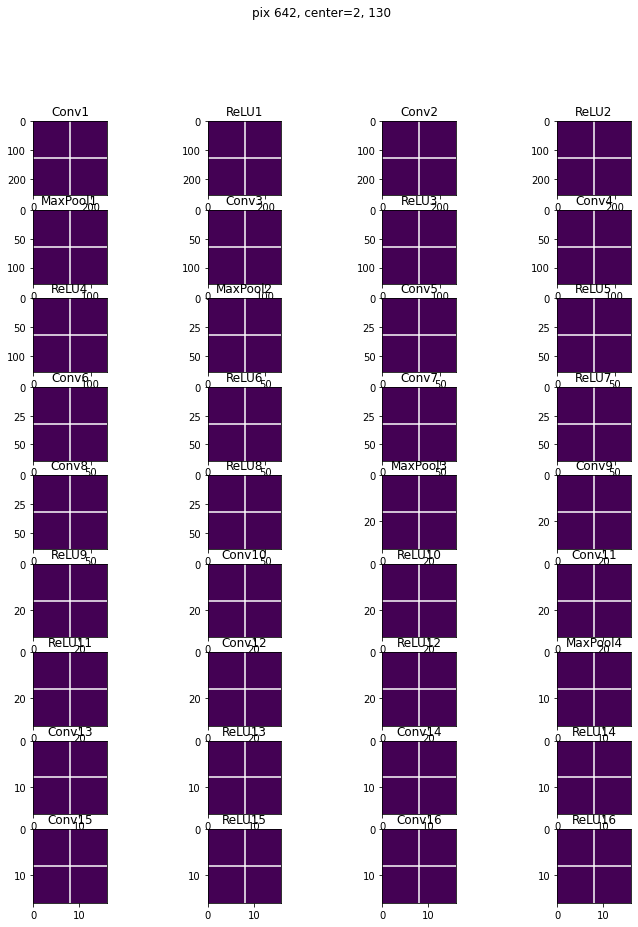

In [11]:
# pix_inds = np.arange(630, 643)
pix_inds = [638, 642]

for pix_ind in pix_inds:

    plt.figure(figsize=(12,16));

    pi=0
    for ll in range(len(layer_names_use)-1):

        rf = rfs_each_layer[ll][pix_ind,:]
        res = res_each_layer[ll]
        rf = np.reshape(rf, [res, res])

        pi+=1
        plt.subplot(10,4,pi)
        plt.pcolormesh(rf)
        plt.axis('square')
        plt.gca().invert_yaxis()
        plt.axhline(res/2, color='w')
        plt.axvline(res/2, color='w')
        plt.title(layer_names_use[ll])
        
    plt.suptitle('pix %d, center=%d, %d'%(pix_ind, pixel_centers[pix_ind][0], pixel_centers[pix_ind][1])) 

In [136]:
256*2 + 128

640

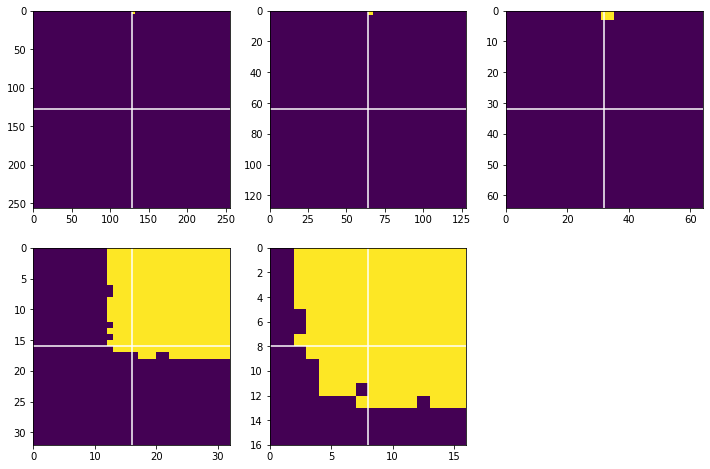

In [134]:
pix_ind = 642

plt.figure(figsize=(12,8));

pi=0
for ll in range(5):
    
    rf = rfs_each_layer[ll][pix_ind,:]
    res = res_each_layer[ll]
    rf = np.reshape(rf, [res, res])

    pi+=1
    plt.subplot(2,3,pi)
    plt.pcolormesh(rf)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.axhline(res/2, color='w')
    plt.axvline(res/2, color='w')

642 2 130
642 2 130
642 2 130
642 2 130


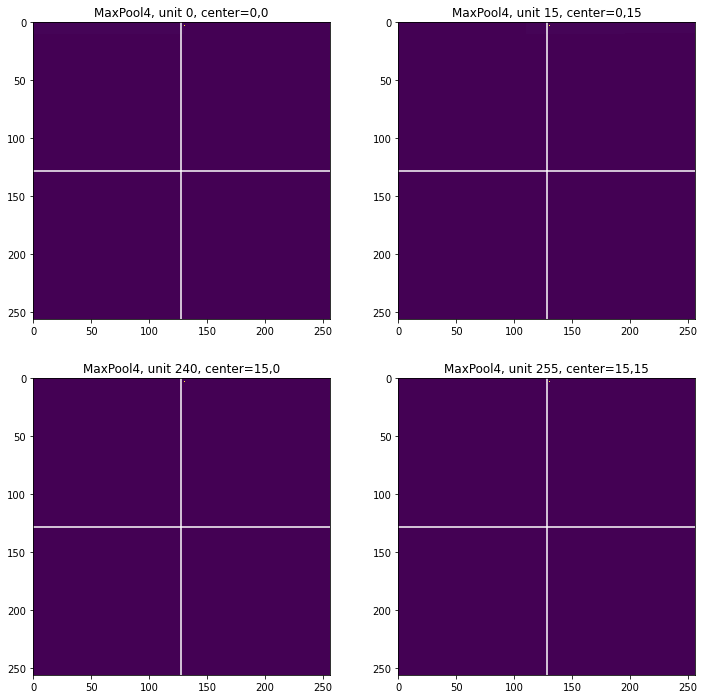

In [135]:
plt.figure(figsize=(12,12))

ll = 4;

units_plot = [0, 16-1, 16*15, 16*16-1]

pi=0
for unit in units_plot:

    pi+=1
    plt.subplot(2,2,pi)
    rf = rfs_each_layer[ll][:,unit]
    rf = np.reshape(rf, [n_pix, n_pix])
    pix_ind = 256*2+130;
    print(pix_ind, pixel_centers[pix_ind][0], pixel_centers[pix_ind][1])
    rf[pixel_centers[pix_ind][0], pixel_centers[pix_ind][1]] = 100;
    plt.pcolormesh(rf)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.axhline(n_pix/2, color='w')
    plt.axvline(n_pix/2, color='w')
    # plt.colorbar()
    plt.title('%s, unit %d, center=%d,%d'%(layer_names_use[ll], unit, \
                                           layer_unit_centers[ll][unit][0], layer_unit_centers[ll][unit][1]))

In [118]:
pix_ind

632

In [95]:
np.flipud(np.array(pixel_centers))

array([[  0,   0],
       [  1,   0],
       [  2,   0],
       ...,
       [253, 255],
       [254, 255],
       [255, 255]])

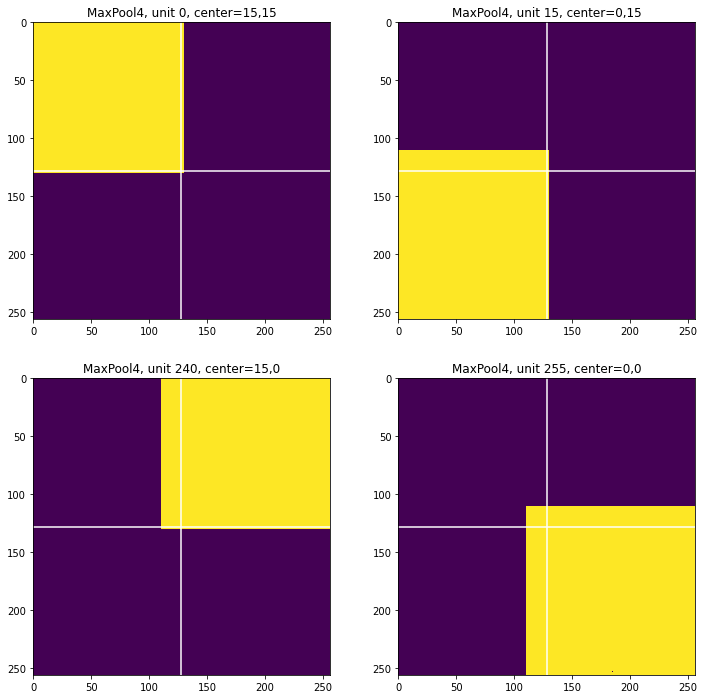

In [77]:
plt.figure(figsize=(12,12))

ll = 4;

units_plot = [0, 16-1, 16*15, 16*16-1]

pi=0
for unit in units_plot:

    pi+=1
    plt.subplot(2,2,pi)
    rf = rfs_each_layer[ll][:,unit].detach().cpu().numpy()
    rf = np.reshape(rf, [n_pix, n_pix])
    plt.pcolormesh(rf)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.axhline(n_pix/2, color='w')
    plt.axvline(n_pix/2, color='w')
    # plt.colorbar()
    plt.title('%s, unit %d, center=%d,%d'%(layer_names_use[ll], unit, \
                                           layer_unit_centers[ll][unit][0], layer_unit_centers[ll][unit][1]))

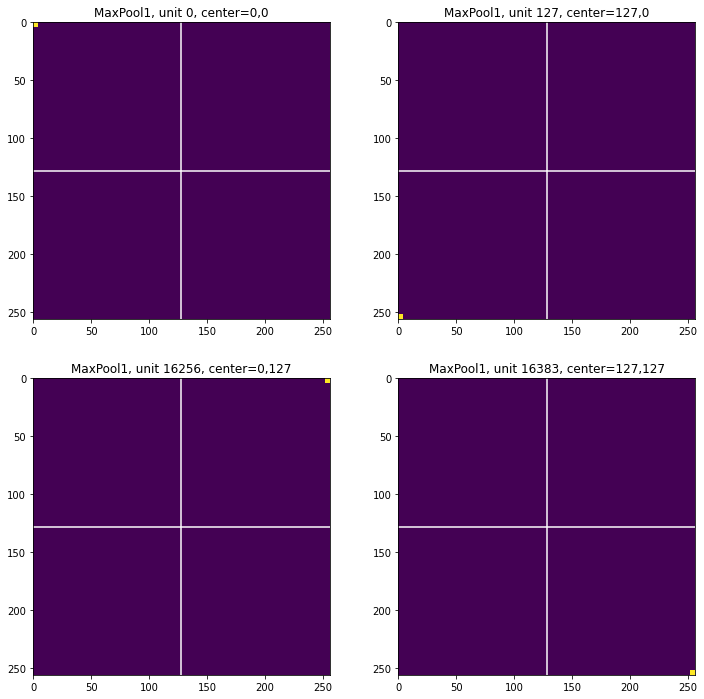

In [62]:
plt.figure(figsize=(12,12))

ll = 1;

units_plot = [0, 128-1, 128*127, 128*128-1]

pi=0
for unit in units_plot:

    pi+=1
    plt.subplot(2,2,pi)
    rf = rfs_each_layer[ll][:,unit].detach().cpu().numpy()
    rf = np.reshape(rf, [n_pix, n_pix])
    plt.pcolormesh(rf)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.axhline(n_pix/2, color='w')
    plt.axvline(n_pix/2, color='w')
    # plt.colorbar()
    plt.title('%s, unit %d, center=%d,%d'%(layer_names_use[ll], unit, \
                                           layer_unit_centers[ll][unit][0], layer_unit_centers[ll][unit][1]))

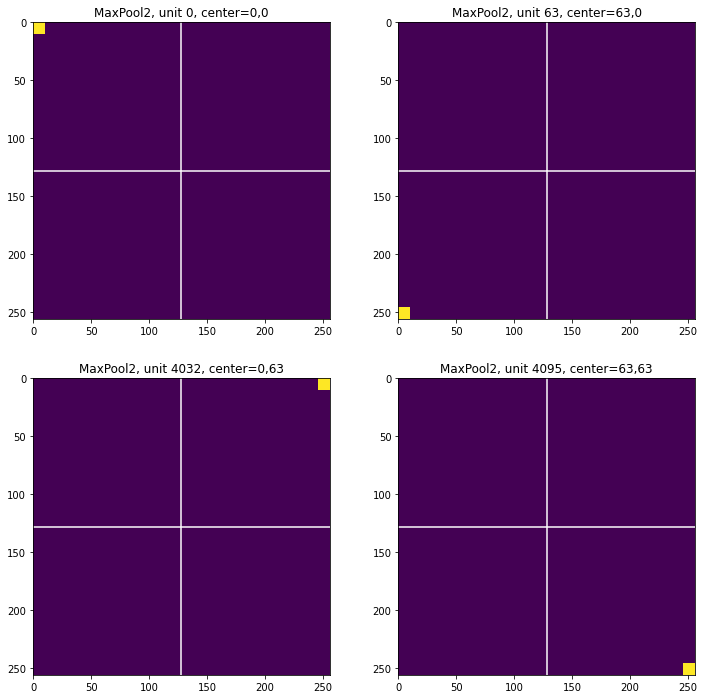

In [63]:
plt.figure(figsize=(12,12))

ll = 2;

units_plot = [0, 64-1, 64*63, 64*64-1]

pi=0
for unit in units_plot:

    pi+=1
    plt.subplot(2,2,pi)
    rf = rfs_each_layer[ll][:,unit].detach().cpu().numpy()
    rf = np.reshape(rf, [n_pix, n_pix])
    plt.pcolormesh(rf)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.axhline(n_pix/2, color='w')
    plt.axvline(n_pix/2, color='w')
    # plt.colorbar()
    plt.title('%s, unit %d, center=%d,%d'%(layer_names_use[ll], unit, \
                                           layer_unit_centers[ll][unit][0], layer_unit_centers[ll][unit][1]))

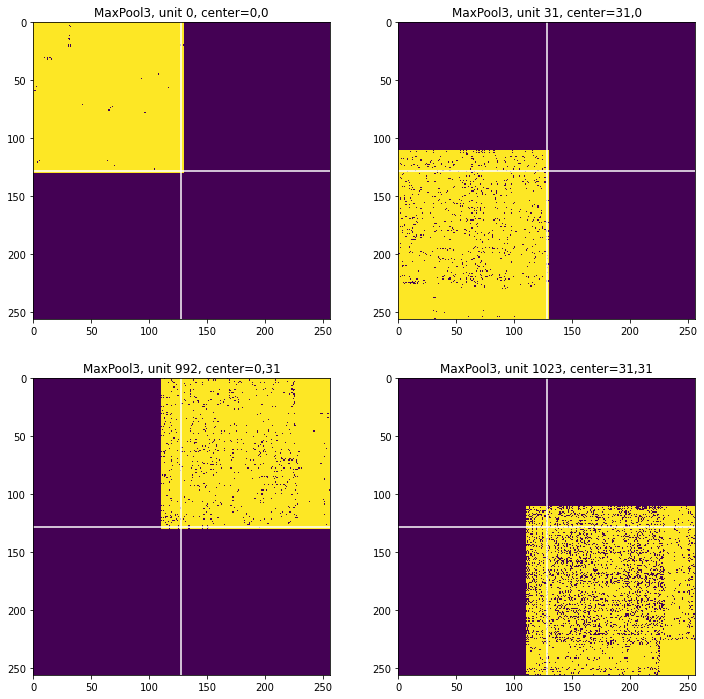

In [65]:
plt.figure(figsize=(12,12))

ll = 3;

units_plot = [0, 32-1, 32*31, 32*32-1]

pi=0
for unit in units_plot:

    pi+=1
    plt.subplot(2,2,pi)
    rf = rfs_each_layer[ll][:,unit].detach().cpu().numpy()
    rf = np.reshape(rf, [n_pix, n_pix])
    plt.pcolormesh(rf)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.axhline(n_pix/2, color='w')
    plt.axvline(n_pix/2, color='w')
    # plt.colorbar()
    plt.title('%s, unit %d, center=%d,%d'%(layer_names_use[ll], unit, \
                                           layer_unit_centers[ll][unit][0], layer_unit_centers[ll][unit][1]))

In [92]:
# layer_unit_centers[ll]

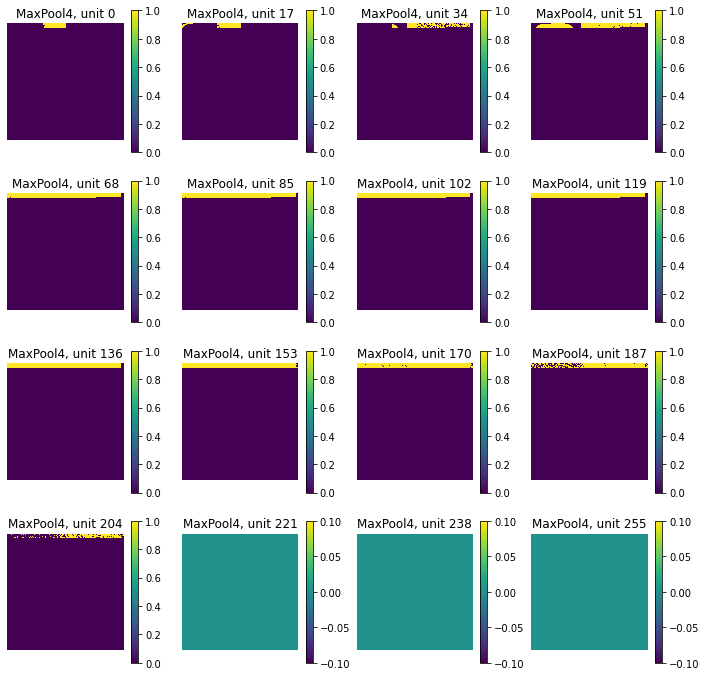

In [10]:
plt.figure(figsize=(12,12))

ll = 4;
n_units = rfs_each_layer[ll].shape[1]
n_units_plot = 16;
units2plot = np.floor(np.linspace(0, n_units-1, n_units_plot)).astype(int)

pi=0
for unit in units2plot:
    
    pi+=1
    plt.subplot(4,4,pi);
    rf = rfs_each_layer[ll][:,unit].detach().cpu().numpy()
    rf = np.reshape(rf, [n_pix, n_pix])
    plt.pcolormesh(rf)
    plt.colorbar()
    plt.title('%s, unit %d'%(layer_names_use[ll], unit))
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    

In [76]:
np.min(a), np.max(a)

(0.0, 73081550000.0)

In [77]:
np.sum(a>0)

15

In [18]:
# for f in model.features:
#     if hasattr(f, 'weight'):
#         print(f.weight)

In [15]:
hasattr(f, 'weight')

False

In [3]:
class a():
    def __init__(self, n_ims_do=10, n_steps=100, debug=0):
        self.n_ims_do = n_ims_do
        self.n_steps = n_steps
        self.debug = debug
        

In [4]:
args = a()

In [5]:
ii=0;

print('\nim %d of %d'%(ii, args.n_ims_do))
        
target_image_filename = info_df['filename_raw'].iloc[ii]
print('processing target image %s'%target_image_filename)
sys.stdout.flush()

cocoid = target_image_filename.split('/')[-1].split('.')[0]

out_dir = os.path.join('/user_data/mmhender/stimuli/texture_synth_images', 'coco_%s'%cocoid)
print('will save images to %s'%out_dir)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

root = os.getcwd()
model_path = os.path.join(root, 'models','VGG19_normalized_avg_pool_pytorch')

args.lr = 1.0
args.max_iter = 20
args.checkpoint_every = 1
if args.debug:
    args.n_steps = 1
args.rndseed = None

# load model & data
target_image = utilities.preprocess_image(
    utilities.load_image(target_image_filename)
)



im 0 of 10
processing target image /lab_data/tarrlab/common/datasets/COCO/train2017/000000326021.jpg
will save images to /user_data/mmhender/stimuli/texture_synth_images/coco_000000326021


In [6]:
important_layers = ['relu1_1', 'pool1','pool2','pool3','pool4']

ll=4;

        # for ll in range(len(important_layers)):
            
layers_match = important_layers[0:ll+1]
print('making texture for layers:')
print(layers_match)
sys.stdout.flush()

making texture for layers:
['relu1_1', 'pool1', 'pool2', 'pool3', 'pool4']


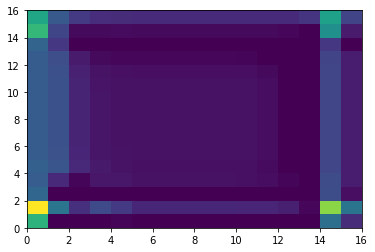

In [199]:
plt.figure();
plt.pcolormesh(activs[30][0,1,:,:].detach().cpu().numpy())

In [7]:

def gram_matrix_spatweighted(activations: torch.Tensor, spatial_weights: torch.Tensor = None) -> torch.Tensor:
    b, n, x, y = activations.size()
    print((b,n,x,y))
    activations_weighted = activations  
    activation_matrix = activations.view(b * n, x * y)
    G = torch.mm(activation_matrix, activation_matrix.t())    # gram product
    return G.div(b * n * x * y)     # normalization


In [8]:
def make_square_grid_smooth(n_grid_eachside=2, n_pix=256, ramp_size=20):

    n_grid_total = n_grid_eachside**2
    grid_bounds = np.floor(np.linspace(0,n_pix, n_grid_eachside+1)).astype(int)

    # define ramping edge function (squared cosine)
    xvals_ramp = np.linspace(-np.pi/2,0, ramp_size)
    ramp_vals = np.cos(xvals_ramp)**2
    
    # for the corners, use distance from corner to get round edge
    center = [0,0]
    x, y = np.meshgrid(np.arange(ramp_size), np.arange(ramp_size))
    distance = np.sqrt((x-center[0])**2 + (y-center[1])**2)
    distance /= (ramp_size-1)
    distance = -distance * np.pi/2
    distance = np.maximum(distance, -np.pi/2)
    ramp_corner = np.cos(distance)**2

    spatial_weights_pixel = np.zeros((n_pix, n_pix, n_grid_total))

    gt = -1;
    for gx in range(n_grid_eachside):
        for gy in range(n_grid_eachside):

            gt+=1
            # xrange = np.arange(grid_bounds[gx], grid_bounds[gx+1])
            # yrange = np.arange(grid_bounds[gy], grid_bounds[gy+1])
            xrange = [grid_bounds[gx], grid_bounds[gx+1]]
            yrange = [grid_bounds[gy], grid_bounds[gy+1]]

            spatial_weights_pixel[xrange[0]:xrange[1], yrange[0]:yrange[1], gt] = 1

            # add in ramp for each edge region 
            # (there is probably a more efficient way to do this...)
            if xrange[0]>0:

                ydist = yrange[1]-yrange[0]
                ramp_tiled = np.tile(ramp_vals[:,None], [1, int(ydist)])
                spatial_weights_pixel[xrange[0]-ramp_size: xrange[0], \
                                      yrange[0]:yrange[1], gt] = \
                                        ramp_tiled

            if xrange[1]<n_pix:

                ydist = yrange[1]-yrange[0]
                ramp_tiled = np.tile(np.flipud(ramp_vals[:,None]), [1, int(ydist)])
                spatial_weights_pixel[xrange[1]: xrange[1]+ramp_size, \
                                      yrange[0]:yrange[1], gt] = \
                                        ramp_tiled


            if yrange[0]>0:

                xdist = xrange[1]-xrange[0]
                ramp_tiled = np.tile(ramp_vals[None,:], [int(xdist),1])
                spatial_weights_pixel[xrange[0]:xrange[1], \
                                      yrange[0]-ramp_size:yrange[0], gt] = \
                                        ramp_tiled

            if yrange[1]<n_pix:

                xdist = xrange[1]-xrange[0]
                ramp_tiled = np.tile(np.fliplr(ramp_vals[None,:]), [int(xdist),1])
                spatial_weights_pixel[xrange[0]:xrange[1], \
                                      yrange[1]:yrange[1]+ramp_size, gt] = \
                                        ramp_tiled

            # now add in the ramps for corner regions
            if xrange[0]>0 and yrange[0]>0:

                spatial_weights_pixel[xrange[0]-ramp_size: xrange[0], 
                                      yrange[0]-ramp_size: yrange[0], gt] = \
                                        np.flipud(np.fliplr(ramp_corner))

            if xrange[0]>0 and yrange[1]<n_pix:

                spatial_weights_pixel[xrange[0]-ramp_size: xrange[0], 
                                      yrange[1]: yrange[1]+ramp_size, gt] = \
                                        np.flipud(ramp_corner)

            if xrange[1]<n_pix and yrange[0]>0:

                spatial_weights_pixel[xrange[1]: xrange[1]+ramp_size, 
                                      yrange[0]-ramp_size: yrange[0], gt] = \
                                        np.fliplr(ramp_corner)

            if xrange[1]<n_pix and yrange[1]<n_pix:

                spatial_weights_pixel[xrange[1]: xrange[1]+ramp_size, 
                                      yrange[1]: yrange[1]+ramp_size, gt] = \
                                        ramp_corner


    return spatial_weights_pixel

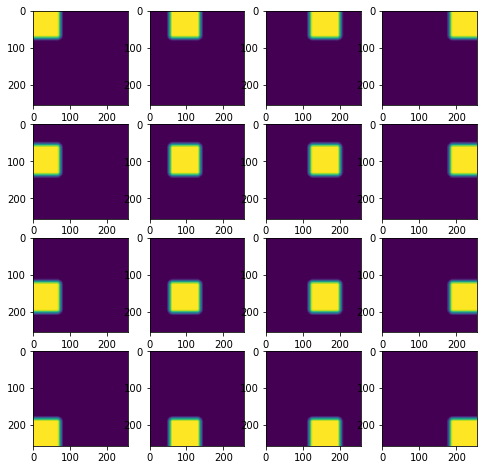

In [9]:
n_grid_eachside=4
n_pix=256
spatial_weights_pixel = make_square_grid_smooth(n_grid_eachside=n_grid_eachside, n_pix=n_pix)

plt.figure(figsize=(8,8))
gt = 0;
for gx in range(n_grid_eachside):
    for gy in range(n_grid_eachside):

        
        plt.subplot(n_grid_eachside, n_grid_eachside, gt+1)
        plt.pcolormesh(spatial_weights_pixel[:,:,gt])
        plt.axis('square')
        plt.gca().invert_yaxis()
        gt+=1

In [15]:
map_res_in = 256;
map_res_out = 256;

unit_centers_x, unit_centers_y = np.meshgrid(np.arange(map_res_out), np.arange(map_res_out))
unit_centers = list(zip(np.ravel(unit_centers_x), np.ravel(unit_centers_y)))
n_spat_units_out = len(unit_centers)

# unit_receptive_fields = np.zeros((n_spat_units_out, map_res_in, map_res_in))
unit_rf_matrix = np.zeros((n_spat_units_out, map_res_in**2))

ks = 3;
ks_half = int(np.floor(ks/2))
for uu, center in enumerate(unit_centers):
    
    rf = np.zeros((map_res_in, map_res_in))
   
    # first convolutional layer
    xmin = np.maximum(center[0]-ks_half, 0)
    ymin = np.maximum(center[1]-ks_half, 0)
    rf[xmin:center[0]+ks_half+1, ymin:center[1]+ks_half+1] = 1
    
    unit_rf_matrix[uu] = rf.ravel()
    

In [20]:
len(unit_rf_matrix[uu])

65536

In [13]:
unit_receptive_fields=None

In [34]:
map_res_in = 256
pool_size = 2
map_res_out = int(np.ceil(map_res_in/pool_size))
n_spat_units_in = map_res_in**2
n_spat_units_out = map_res_out**2

unit_centers_x, unit_centers_y = np.meshgrid(np.arange(map_res_out), np.arange(map_res_out))
unit_centers = list(zip(np.ravel(unit_centers_x), np.ravel(unit_centers_y)))

In [24]:
unit_centers[0][0]

0

In [33]:
pooling_rf_matrix = np.zeros((n_spat_units_out, n_spat_units_in))

for uu, center in enumerate(unit_centers):
    
    rf = np.zeros((map_res_in, map_res_in))

    # pooling
    xmin = center[0]*pool_size
    xmax = center[0]*pool_size+2
    ymin = center[1]*pool_size
    ymax = center[1]*pool_size+2
    
    rf[xmin:xmax, ymin:ymax] = 1;
    
    pooling_rf_matrix[uu,:] = rf.ravel()

In [36]:
pooling_rf_matrix.shape

(16384, 65536)

In [ ]:
comb = pooling_rf_matrix @ unit_rf_matrix

In [ ]:
pooling_rf_tensor = torch.Tensor(pooling_rf_matrix).to(device)
unit_rf_tensor = torch.Tensor(unit_rf_matrix).to(device)

4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


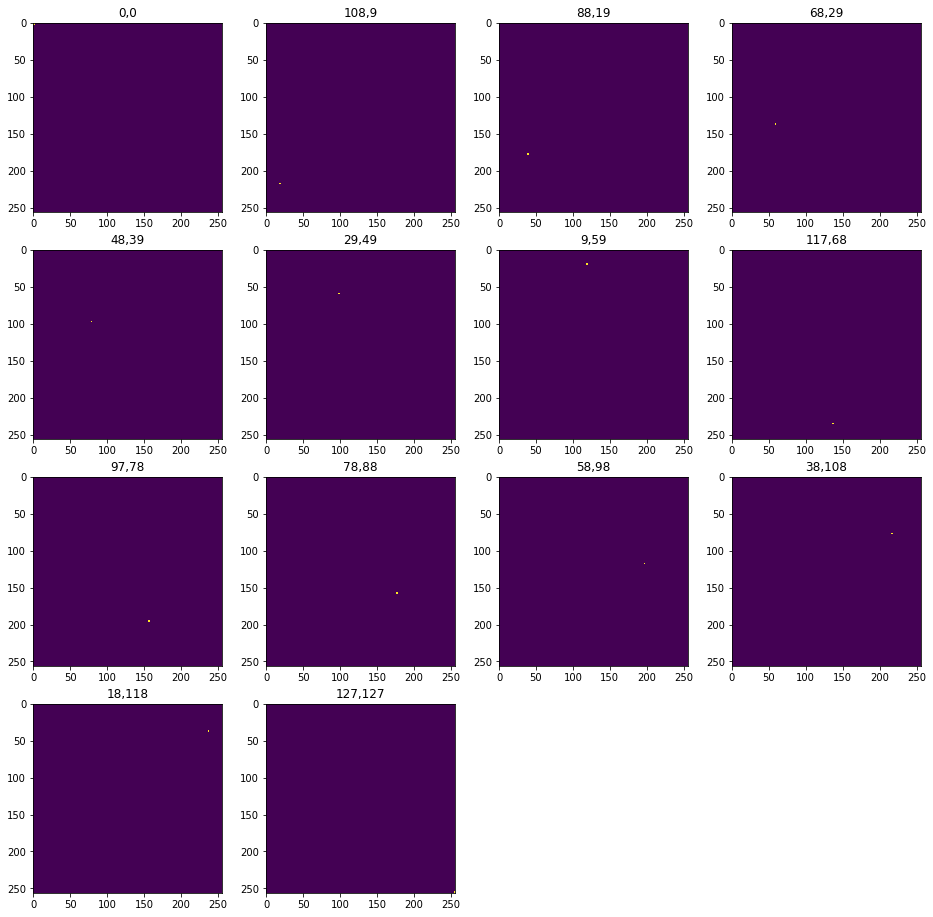

In [35]:
n_plot = 14;

units_plot = np.linspace(0,n_spat_units_out-1, n_plot).astype(int)

plt.figure(figsize=(16,16))

pi=0;
for uu in units_plot:
        
    pi+=1
    plt.subplot(4,4,pi)
    rf = np.reshape(pooling_rf_matrix[uu],(map_res_in, map_res_in))
    plt.pcolormesh(rf) 
    print(np.sum(rf))
    plt.axis('square')
    plt.gca().invert_yaxis()
    gt+=1
    plt.title('%s,%s'%(unit_centers[uu]))

4.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
4.0


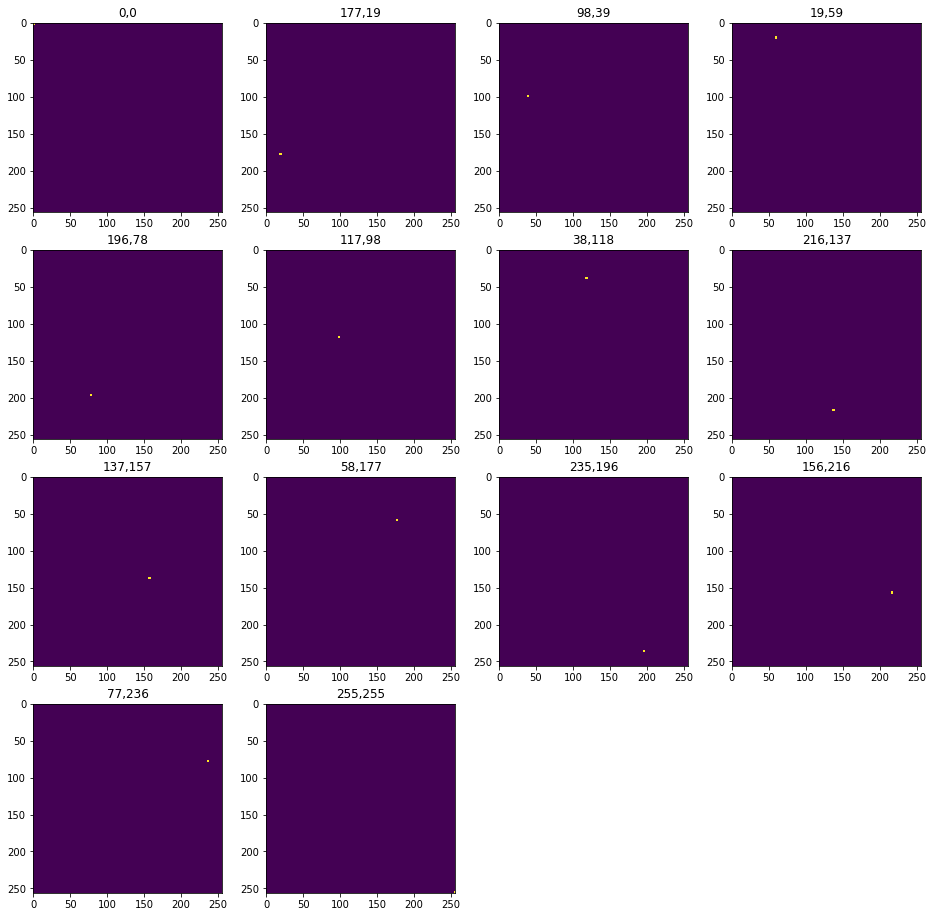

In [16]:
n_plot = 14;

units_plot = np.linspace(0,n_spat_units_out-1, n_plot).astype(int)

plt.figure(figsize=(16,16))

pi=0;
for uu in units_plot:
        
    pi+=1
    plt.subplot(4,4,pi)
    rf = np.reshape(unit_rf_matrix[uu],(map_res_in, map_res_in))
    plt.pcolormesh(rf) 
    print(np.sum(rf))
    plt.axis('square')
    plt.gca().invert_yaxis()
    gt+=1
    plt.title('%s,%s'%(unit_centers[uu]))

In [219]:
units_plot

array([    0,  5041, 10082, 15123, 20164, 25206, 30247, 35288, 40329,
       45371, 50412, 55453, 60494, 65536])

In [220]:
len(unit_centers)

65536

In [10]:
from typing import List, Tuple

import torch

import utilities


class Model:
    def __init__(
        self, path: str, device: torch.device, target_image: torch.Tensor,
        layer_weights: List[float] = [1e09, 1e09, 1e09, 1e09, 1e09],
        important_layers: List[str] = [
            'relu1_1', 'pool1', 'pool2', 'pool3', 'pool4'
        ],
        n_pooling_regions: int = 1,
    ):
        self.net = utilities.load_model(path).to(device).eval()
        self.device = device
        self.target_image = target_image.to(device)
        self.layer_weights = layer_weights
        self.important_layers = important_layers
        # print(self.important_layers)
        
        self.n_total_grid = n_pooling_regions**2
        
        # extract Gram matrices of the target image
        gram_hook = GramHook()
        gram_hook_handles = []
        for name, layer in self.net.named_children():
            if name in self.important_layers:
                # print('adding hook for %s'%name)
                handle = layer.register_forward_hook(gram_hook)
                gram_hook_handles.append(handle)
        self.net(self.target_image)

        # register Gram loss hook
        self.gram_loss_hook = GramLossHook(
            gram_hook.gram_matrices, layer_weights, important_layers
        )
        for handle in gram_hook_handles:    # Gram hook is not needed anymore
            handle.remove()

        for name, layer in self.net.named_children():
            if name in self.important_layers:
                # print('adding loss hook for %s'%name)
                handle = layer.register_forward_hook(self.gram_loss_hook)

        # print([name for [name, l] in self.net.named_children()])
        # remove unnecessary layers
        i = 0
        for name, layer in self.net.named_children():
            if name == important_layers[-1]:
                break
            i += 1
        self.net = self.net[:(i + 1)]
        # print([name for [name, l] in self.net.named_children()])
        
    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        self.gram_loss_hook.clear()

        return self.net(image)

    def get_loss(self) -> torch.Tensor:
        # return sum(self.gram_loss_hook.losses)
        return torch.stack(self.gram_loss_hook.losses, dim=0).sum(dim=0)

    
class GramHook:
    def __init__(self):
        self.gram_matrices = []

    def __call__(
        self, layer: torch.nn.Module, layer_in: Tuple[torch.Tensor],
        layer_out: torch.Tensor
    ):
        gram_matrix = gram_matrix_spatweighted(layer_out.detach())
        print(gram_matrix.shape)
        self.gram_matrices.append(gram_matrix)


class GramLossHook:
    def __init__(
        self, target_gram_matrices: List[torch.Tensor],
        layer_weights: List[float], layer_names: List[str]
    ):
        self.target_gram_matrices = target_gram_matrices
        self.layer_weights = [
            weight * (1.0 / 4.0) for weight in layer_weights
        ]
        self.layer_names = layer_names
        self.losses: List[torch.Tensor] = []

    def __call__(
        self, layer: torch.nn.Module, layer_in: Tuple[torch.Tensor],
        layer_out: torch.Tensor
    ):
        i = len(self.losses)
        assert i < len(self.layer_weights)
        assert i < len(self.target_gram_matrices)

        if torch.isnan(layer_out).any():
            print('NaN in layer {}, NaN already in layer input: {}'.format(
                self.layer_names[i], torch.isnan(layer_in[0]).any()
            ))

        opt_gram_matrix = gram_matrix_spatweighted(layer_out)
        loss = self.layer_weights[i] * (
            (opt_gram_matrix - self.target_gram_matrices[i])**2
        ).sum()
        print(loss)
        self.losses.append(loss)

    def clear(self):
        self.losses = []
